In [1]:
import sys
sys.path.insert(0, "../")

from datasets import load_dataset
from omegaconf import OmegaConf

import numpy as np
import torch
from einops import rearrange
from huggingface_hub import hf_hub_download
from IPython.utils import io
from torch.utils.data import DataLoader

from ldm.models.diffusion.plms import PLMSSampler
from ldm.util import instantiate_from_config
from utils import collate_fn, show

## Load Satellite Dataset

In [2]:
MAG = "3x" # The sample dataset has 1x, 2x, 3x and 4x data

ds = load_dataset("StonyBrook-CVLab/ZoomLDM-demo-dataset-NAIP", name=MAG, trust_remote_code=True, split='train')
dl = DataLoader(ds, batch_size=4, collate_fn = collate_fn)

In [3]:
batch = next(iter(dl))

# Images are always 256x256
print("Images:", batch['image'].shape)

# Magnification is encoded into 0-3
MAG_DICT = {
    "1x": 0,
    "2x": 1,
    "3x": 2,
    "4x": 3,
}
print("Magnifications:", batch['mag'])

# We extract a DINO-v2 SSL embedding for each 256x256 patch in the image and arrange them spatially
# e.g. 3x -> (4,4) SSL embeddings
# We use pretrained dinov2_vitl14_reg
print("SSL Features:", batch['ssl_feat'].shape)

Images: torch.Size([4, 256, 256, 3])
Magnifications: tensor([2, 2, 2, 2])
SSL Features: torch.Size([4, 1024, 4, 4])


## Load ZoomLDM

In [5]:
device = torch.device('cuda:0')
torch.cuda.set_device(0)

ckpt_path = hf_hub_download(repo_id="StonyBrook-CVLab/ZoomLDM", filename="naip/weights.ckpt")
state_dict = torch.load(ckpt_path, weights_only=False)

config_path = hf_hub_download(repo_id="StonyBrook-CVLab/ZoomLDM", filename="naip/config.yaml")
config = OmegaConf.load(config_path)

with io.capture_output() as _:
    model = instantiate_from_config(config.model)
model = model.to(device).eval()
model.load_state_dict(state_dict);

# disable null token 
model.cond_stage_model.p_uncond = 0
sampler = PLMSSampler(model)

## Sample

In [6]:
# Generation parameters
ddim_steps = 50
cfg_scale = 2
shape = [3,64,64]

# Generation loop
with torch.no_grad(), model.ema_scope(), torch.autocast(dtype=torch.float16, device_type="cuda"):
    for k in ['ssl_feat', 'mag']:
        batch[k] = batch[k].to(device)

    cc = model.get_learned_conditioning(batch)
    uc = torch.zeros_like(cc)

    samples_ddim, _ = sampler.sample(
        S=ddim_steps,
        conditioning=cc,
        batch_size=len(batch["ssl_feat"]),
        shape=shape,
        verbose=False,
        unconditional_guidance_scale=cfg_scale,
        unconditional_conditioning=uc,
    )

    x_samples_ddim = model.decode_first_stage(samples_ddim)
    x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples_ddim = (255 * x_samples_ddim.cpu().numpy()).astype(np.uint8)

/home/myellapragad/spring25/ZoomLDM/notebooks/../ldm/models/diffusion/ddpm.py:1087: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


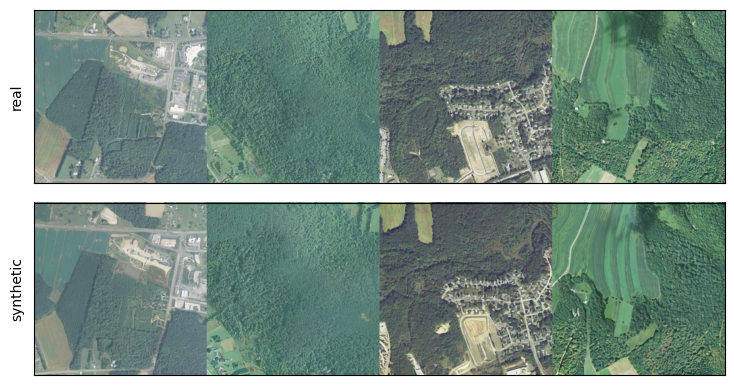

In [7]:
real = rearrange(batch['image'], "n h w c -> h (n w) c")

syn = rearrange(x_samples_ddim, "n c h w -> h (n w) c")

show([real, syn], ["real", "synthetic"])